# Gaussian Linear Dynamical System 

In this notebook, we will look at how we can fit a "Gaussian Linear Dynamical System," using the StateSpaceDynamics package. This model is a powerful tool for analyzing time series data and understanding underlying latent processes. For a reference of the details of this model please refer to Chapter 13.3 of Pattern Recognition and Machine Learning by Christopher Bishop.

## Setup

In [1]:
# import the relevant packages
using StateSpaceDynamics
using LinearAlgebra
using Random
using Plots
using LaTeXStrings

## Simulate a Gaussian LDS model

In [2]:
# create a state-space model for the tutorial
obs_dim = 10
latent_dim = 2

# set up the state parameters
A = 0.95 * [cos(0.25) -sin(0.25); sin(0.25) cos(0.25)] 
Q = Matrix(0.1 * I(2))

x0 = [0.0; 0.0]
P0 = Matrix(0.1 * I(2))

# set up the observation parameters
C = randn(obs_dim, latent_dim)
R = Matrix(0.5 * I(10))


# create the state-space model
true_ssm = GaussianLDS(;A=A, 
                        Q=Q, 
                        C=C, 
                        R=R, 
                        x0=x0, 
                        P0=P0, 
                        obs_dim=obs_dim, 
                        latent_dim=latent_dim, 
                        fit_bool=fill(true, 6))

# simulate data from the model
tSteps = 500
latents, observations = StateSpaceDynamics.sample(true_ssm, tSteps, 1) # one trial for tutorial purposes

([-0.6836391623408911 -0.3818906459494757 … -0.657948678035869 -0.3008576096489386; -0.7103656778164311 -0.7719011174206681 … -0.9335214797496181 -0.35677834543776754;;;], [-2.0269611502334457 -1.5047057487908142 … -1.349691115698279 -1.0823466757759155; 0.29525373025765367 1.4839924841261354 … 0.7877111679537219 -0.6722321884827978; … ; -1.257570533114868 -1.3912443174293176 … -2.094411171361362 -0.18808982318321932; -2.075531908938146 -0.06667220755365627 … -0.8916822553440433 -0.2011450954064352;;;])

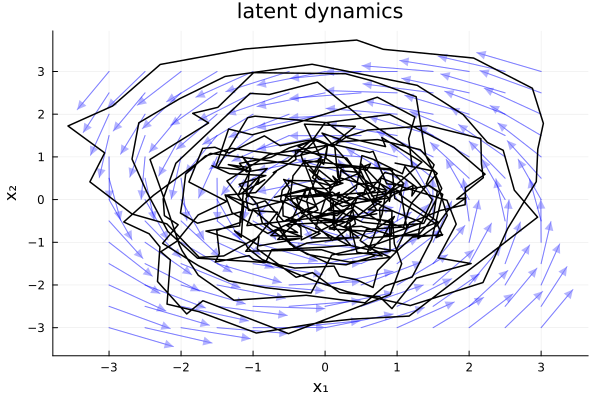

In [3]:
# Create a grid for the vector field
x = y = -3:0.5:3
X = repeat(x', length(y), 1)
Y = repeat(y, 1, length(x))

# Assuming x and y are your grid points
U = zeros(size(X))
V = zeros(size(Y))
for i in 1:size(X, 1)
    for j in 1:size(X, 2)
        v = A * [X[i,j], Y[i,j]]
        U[i,j] = v[1] - X[i,j]  # Change in x
        V[i,j] = v[2] - Y[i,j]  # Change in y
    end
end
# Normalize the vectors for better visualization
magnitude = @. sqrt(U^2 + V^2)
U_norm, V_norm = U ./ magnitude, V ./ magnitude

magnitude = @. sqrt(U^2 + V^2)
U_norm = U ./ magnitude
V_norm = V ./ magnitude

# Plot
p = quiver(X, Y, quiver=(U_norm, V_norm), color=:blue, alpha=0.3,
           linewidth=1, arrow=arrow(:closed, :head, 0.1, 0.1))
plot!(latents[1, :, 1], latents[2, :, 1], xlabel="x₁", ylabel="x₂", color=:black, linewidth=1.5, title="latent dynamics", legend=false)


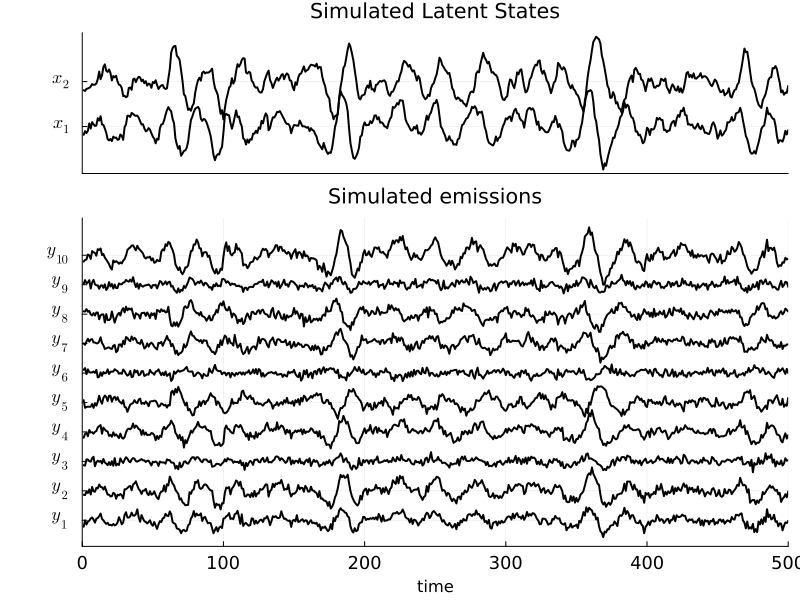

In [4]:
# Define parameters
state_dim = 2
obs_dim = 10
time_bins = 500

# Generate sample data
states = latents[:, :, 1]
emissions = observations[:, :, 1]

# Create the main plot
plot(size=(800, 600), layout=@layout[a{0.3h}; b])

# Plot the continuous latent states
lim_states = maximum(abs.(states))
for d in 1:state_dim
    plot!(1:time_bins, states[d, :] .+ lim_states * (d-1), color=:black, linewidth=2, label="", subplot=1)
end
plot!(subplot=1, yticks=(lim_states .* (0:state_dim-1), [L"x_%$d" for d in 1:state_dim]),
      xticks=[], xlims=(0, time_bins), title="Simulated Latent States",
      yformatter=y->"", tickfontsize=12)

# Plot the emissions
lim_emissions = maximum(abs.(emissions))
for n in 1:obs_dim
    plot!(1:time_bins, emissions[n, :] .- lim_emissions * (n-1), color=:black, linewidth=2, label="", subplot=2)
end
plot!(subplot=2, yticks=(-lim_emissions .* (obs_dim-1:-1:0), [L"y_{%$n}" for n in 1:obs_dim]),
      xlabel="time", xlims=(0, time_bins), title="Simulated emissions",
      yformatter=y->"", tickfontsize=12)

# Adjust layout
plot!(link=:x, size=(800, 600), left_margin=10Plots.mm)

# Display the plot
display(current())

# Uncomment to save the figure
# savefig("simulated_latent_states_and_emissions.png")

## Create and fit a Gaussian LDS model to Data

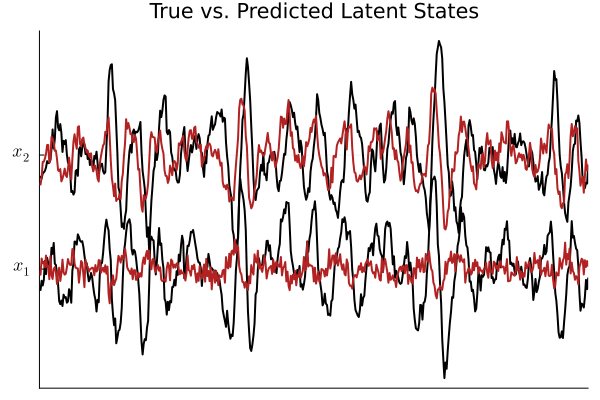

In [5]:
# create a Gaussian LDS with unknow parameters (except the dimensions)
naive_ssm = GaussianLDS(;obs_dim=obs_dim, latent_dim=latent_dim, fit_bool=fill(true, 6))

# smooth the data to look at the predicted latent states
x_smooth, p_smooth, _ = StateSpaceDynamics.smooth(naive_ssm, observations)

# create a plot to compare the true and predicted latent states
plot()

# plot the true latent states
for d in 1:state_dim
    plot!(1:time_bins, states[d, :] .+ lim_states * (d-1), color=:black, linewidth=2, label="", subplot=1)
end

# plot the predicted latent states
for d in 1:state_dim
    plot!(1:time_bins, x_smooth[d, :, 1] .+ lim_states * (d-1), color=:firebrick, linewidth=2, label="", subplot=1)
end

plot!(subplot=1, yticks=(lim_states .* (0:state_dim-1), [L"x_%$d" for d in 1:state_dim]),
      xticks=[], xlims=(0, time_bins), yformatter=y->"", tickfontsize=12, title="True vs. Predicted Latent States")


Fitting LDS via EM... 100%|██████████████████████████████| Time: 0:00:52


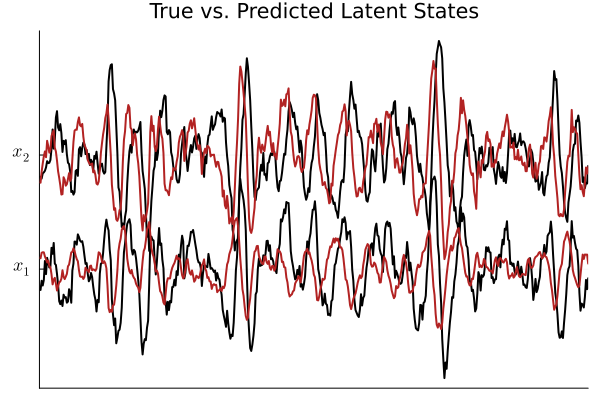

In [6]:
# now fit the LDS using the EM algorithm
elbo, _ = fit!(naive_ssm, observations; max_iter=1000, tol=1e-6)

# smooth the data to look at the predicted latent states
x_smooth, p_smooth, _ = StateSpaceDynamics.smooth(naive_ssm, observations)

# create a plot to compare the true and predicted latent states
plot()

# plot the true latent states
for d in 1:state_dim
    plot!(1:time_bins, states[d, :] .+ lim_states * (d-1), color=:black, linewidth=2, label="", subplot=1)
end

# plot the predicted latent states
for d in 1:state_dim
    plot!(1:time_bins, x_smooth[d, :, 1] .+ lim_states * (d-1), color=:firebrick, linewidth=2, label="", subplot=1)
end

plot!(subplot=1, yticks=(lim_states .* (0:state_dim-1), [L"x_%$d" for d in 1:state_dim]),
      xticks=[], xlims=(0, time_bins), yformatter=y->"", tickfontsize=12, title="True vs. Predicted Latent States")

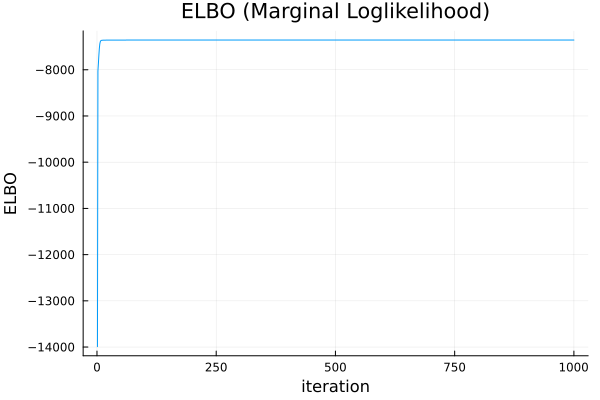

In [7]:
plot(elbo, xlabel="iteration", ylabel="ELBO", title="ELBO (Marginal Loglikelihood)", legend=false)